Análisis de ventas ecommerce y su relación con el PIB per cápita

In [ ]:
#--------------------------------------------------------
#1. IMPORTACIÓN LIBRERIAS
#--------------------------------------------------------
import pandas as pd
import numpy as np

In [3]:
#-------------------------------------------------------
#2. CARGA DE DATOS
#-------------------------------------------------------
#Dataset ecommerce
df_sales = pd.read_csv("../datos/original/OnlineRetail.csv", encoding="latin1")
#Dataset World Development Indicators
df_indicators= pd.read_csv("../datos/original/Indicators.csv")

In [33]:
# -----------------------------------------------------
# 2. LIMPIEZA DATASET ECOMMERCE
# -----------------------------------------------------
df_sales.dropna(inplace=True)
df_sales.drop_duplicates(inplace=True)

#Mostrar primeras filas para examinar el contenido del fichero excel
print(df_sales.head())
print(df_sales.shape)

#Calculamos totales
df_sales['TotalSales']=df_sales['Quantity']*df_sales['UnitPrice']
print(df_sales['TotalSales'])

# Convertimos InvoiceDate a datetime
df_sales['InvoiceDate'] = pd.to_datetime(df_sales['InvoiceDate'], errors='coerce')

# Fechas
df_sales['Year'] = df_sales['InvoiceDate'].dt.year
df_sales['Month'] = df_sales['InvoiceDate'].dt.month
df_sales['Day'] = df_sales['InvoiceDate'].dt.day
df_sales['Weekday'] = df_sales['InvoiceDate'].dt.weekday
df_sales['IsWeekend'] = np.where(df_sales['Weekday'] >= 5, 1, 0)

# Indicadores
threshold = df_sales['TotalSales'].quantile(0.75)
df_sales['IsHighValue'] = np.where(df_sales['TotalSales'] > threshold, 1, 0)
df_sales['DescriptionLength'] = df_sales['Description'].str.len()
df_sales['Qty_x_Price'] = df_sales['Quantity'] * df_sales['UnitPrice']
df_sales['Qty_Squared'] = df_sales['Quantity'] ** 2
df_sales['Log_UnitPrice'] = np.log1p(df_sales['UnitPrice'])
df_sales['Month_x_Day'] = df_sales['Month'] * df_sales['Day']
df_sales['IsLowValue'] = np.where(df_sales['TotalSales'] < df_sales['TotalSales'].quantile(0.25), 1, 0)

print(f"Ecommerce limpio: {df_sales.shape[0]:,} filas y {df_sales.shape[1]} columnas")

# -----------------------------------------------------------
#Exportamos el dataset ecommerce limpio 
# -----------------------------------------------------------
df_sales.to_csv("../datos/procesado/ecommerce_limpio.csv",index=False, float_format='%.2f', sep=';', decimal='.')
print(f"Exportado ecommerce_limpio.csv con {df_sales.shape[0]:,} filas y {df_sales.shape[1]} columnas")


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalSales  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   Year  ...  Day  Weekday  IsWeekend  IsHighValue  DescriptionLength  \
0  2010  ...    1        2          0

In [34]:
# --------------------------------------------------
# 3. LIMPIEZA DATASET INDICADORES
# --------------------------------------------------
# Filtramos solo GDP per capita
df_gdp = df_indicators[df_indicators['IndicatorCode'] == 'NY.GDP.PCAP.CD']

# Nos quedamos con columnas clave
df_gdp = df_gdp[['CountryName', 'Year', 'Value']]
df_gdp.rename(columns={
    'CountryName': 'Country',
    'Value': 'GDP_per_capita'
}, inplace=True)

# Limpiamos
df_gdp.dropna(inplace=True)
df_gdp.drop_duplicates(inplace=True)
df_gdp = df_gdp[df_gdp['GDP_per_capita'] > 100]

print(f"GDP limpio: {df_gdp.shape[0]:,} filas")

# -----------------------------------------------------------
#Exportamos dataset de indicators limpio
# -----------------------------------------------------------
df_gdp.to_csv("../datos/procesado/indicators_limpio.csv",index=False, float_format='%.2f', sep=';', decimal='.')
print(f"Exportado indicators_limpio.csv con {df_sales.shape[0]:,} filas y {df_sales.shape[1]} columnas")



GDP limpio: 10,151 filas
Exportado indicators_limpio.csv con 401,604 filas y 21 columnas


In [35]:
# ------------------------------------------------------
# 5. COMBINACIÓN FINAL SIN AGRUPAR PARA MANTENER +50.000 FILAS
# ------------------------------------------------------
# Normalizamos nombres
df_sales['Country'] = df_sales['Country'].str.strip()
df_gdp['Country'] = df_gdp['Country'].str.strip()

# Combinamos por Country y Year
df_final = pd.merge(df_sales, df_gdp, on=['Country', 'Year'], how='left')

print(f"Dataset final tras la fusión: {df_final.shape[0]:,} filas y {df_final.shape[1]} columnas")


Dataset final tras la fusión: 401,604 filas y 22 columnas


In [ ]:
# ------------------------------------------------------
# 6. EXPORTACIÓN FINAL DEL CONJUNTO DE DATOS FUSIONADO
# ------------------------------------------------------

print("Exportado ecommerce_indicators_final.csv ")
df_final.to_csv("../datos/procesado/ecommerce_indicators_final.csv",
                index=False,
                sep=';',
                decimal=',',
                float_format='%.5f')



Exportado ecommerce_indicators_final.csv 


Estadísticas descriptivas generales:
            Quantity                    InvoiceDate      UnitPrice  \
count  401604.000000                         401604  401604.000000   
mean       12.183273  2011-07-10 12:08:23.848567552       3.474064   
min    -80995.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-29 15:40:00       1.950000   
75%        12.000000            2011-10-20 11:58:30       3.750000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       250.283037                            NaN      69.764035   

          CustomerID     TotalSales           Year          Month  \
count  401604.000000  401604.000000  401604.000000  401604.000000   
mean    15281.160818      20.613638    2010.934378       7.595407   
min     12346.000000 -168469.600000    2010.000000       1.000000   
25%     13939.000000       4.250000    2011.000000      

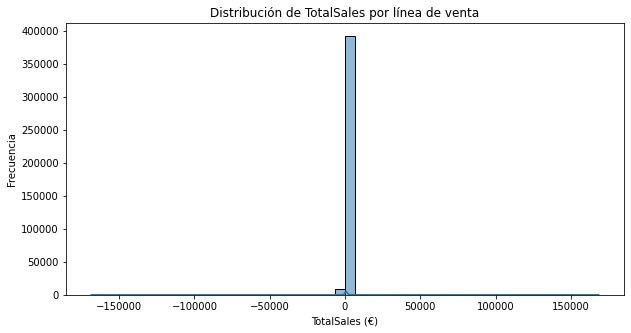

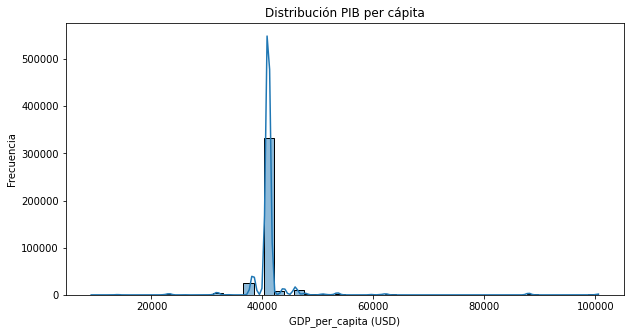


 Ticket medio y PIB per cápita promedio por país:
           Country  TotalSales  GDP_per_capita
0        Australia  108.910787    61936.252744
1          Austria   25.322494    51023.378076
2          Bahrain   32.258824    22238.711950
3          Belgium   19.773301    47542.900583
4           Brazil   35.737500    13042.421933
5           Canada   24.280662    52086.533525
6  Channel Islands   26.520991             NaN
7           Cyprus   21.045434    31649.036886
8   Czech Republic   23.590667    21656.941418
9          Denmark   48.247147    61116.071876


In [28]:
# ================================================================
# 7. ANÁLISIS DESCRIPTIVO Y ESTADÍSTICO DEL DATASET FINAL
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# 1. Estadísticas descriptivas básicas
# -------------------------------------------
print("Estadísticas descriptivas generales:")
print(df_final.describe())

# -------------------------------------------
# 2. Correlación entre PIB per cápita y TotalSales
# -------------------------------------------
print("\n Correlación entre GDP_per_capita y TotalSales:")
print(df_final[['GDP_per_capita', 'TotalSales']].corr())

# -------------------------------------------
# 3. Distribución de TotalSales
# -------------------------------------------
plt.figure(figsize=(10,5))
sns.histplot(df_final['TotalSales'], bins=50, kde=True)
plt.title("Distribución de TotalSales por línea de venta")
plt.xlabel("TotalSales (€)")
plt.ylabel("Frecuencia")
plt.show()

# -------------------------------------------
# 4. Distribución de GDP_per_capita
# -------------------------------------------
plt.figure(figsize=(10,5))
sns.histplot(df_final['GDP_per_capita'], bins=50, kde=True)
plt.title("Distribución PIB per cápita")
plt.xlabel("GDP_per_capita (USD)")
plt.ylabel("Frecuencia")
plt.show()

# -------------------------------------------
# 5. Groupby por país para obtener medias
# -------------------------------------------
df_grouped_country = df_final.groupby('Country').agg({
    'TotalSales': 'mean',
    'GDP_per_capita': 'mean'
}).reset_index()

print("\n Ticket medio y PIB per cápita promedio por país:")
print(df_grouped_country.head(10))
